In [1]:
import math
import os
import ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from FeatureEngineering_2 import *

from joblib import dump, load
from AdvancedModel_helpers import *

In [2]:
if not os.path.exists("csv"):
    os.makedirs("csv")
for year in [2016,2017, 2018, 2019]: # 2020 has been excluded to be reserved as the test set
    read_a_season("../nhl_data/",year).to_csv('csv/tidy_{season}.csv'.format(season = year), sep = ',', index = False)

  0%|          | 0/5456 [00:00<?, ?it/s]

100%|██████████| 5456/5456 [01:42<00:00, 53.04it/s] 


### Consolidating and Sorting CSV Files into a Unified DataFrame

In [153]:
directory = 'csv'

# Get a list of csv file names within the directory
csv_files = [f for f in os.listdir(directory) if f.endswith('.csv')]

# Sort the list of csv files
csv_files.sort()

# List to hold your DataFrames
dataframes_list = []

# Loop over the sorted list of csv files with tqdm for progress indication
for filename in tqdm(csv_files, desc="Loading files", unit="file"):
    file_path = os.path.join(directory, filename)
    df = pd.read_csv(file_path)
    dataframes_list.append(df)

# Concatenate all the DataFrames in the list into a single DataFrame
train_val_df = pd.concat(dataframes_list, ignore_index=True)

# Sort the DataFrame first by 'game_id' and then by 'event_idx'
train_val_df =train_val_df .sort_values(by=['game_id', 'event_idx'])

# Reset the index of the sorted DataFrame
train_val_df = train_val_df .reset_index(drop=True)

Loading files: 100%|██████████| 4/4 [00:01<00:00,  2.69file/s]


In [154]:
train_val_df.head(10)

,game_id,event_idx,play_type,shot_type,shot_dist,game_time,goals_home,goals_away,attack_team_name,period,...,y_coord_last_event,Time_from_the_last_event,Distance_from_the_last_event,Rebound,change_shot_angle,Speed,x,y,angle_net,is_goal
0,2016020978,4,Shot,Wrist Shot,61.294372,9,0,0,Colorado Avalanche,1,...,0.0,9,45.453273,False,NaN,5.050364,-35.0,29.0,-28.237446,0
1,2016020978,5,Shot,Wrist Shot,8.944272,10,0,0,Colorado Avalanche,1,...,29.0,1,54.230987,True,-35.197503,54.230987,-85.0,8.0,-63.434949,0
2,2016020978,16,Shot,Wrist Shot,39.000000,243,0,0,Colorado Avalanche,1,...,35.0,43,108.853112,False,NaN,2.531468,-53.0,15.0,-22.619865,0
3,2016020978,17,Shot,Wrist Shot,39.962482,253,0,0,Carolina Hurricanes,1,...,15.0,10,108.166538,True,25.671421,10.816654,55.0,21.0,31.701430,0
4,2016020978,20,Shot,Wrist Shot,18.867962,349,0,0,Colorado Avalanche,1,...,-32.0,56,20.615528,False,NaN,0.368134,-79.0,-16.0,57.994617,0
5,2016020978,22,Goal,Wrist Shot,49.739320,368,0,1,Carolina Hurricanes,1,...,24.0,3,49.162994,False,NaN,16.387665,46.0,-25.0,-30.173520,1
6,2016020978,28,Shot,Wrist Shot,17.204651,484,0,1,Colorado Avalanche,1,...,-8.0,11,39.357337,False,NaN,3.577940,-75.0,10.0,-35.537678,0
7,2016020978,31,Shot,Wrist Shot,53.000000,551,0,1,Carolina Hurricanes,1,...,-22.0,31,25.709920,False,NaN,0.829352,44.0,-28.0,-31.890792,0
8,2016020978,35,Shot,Wrist Shot,60.033324,562,0,1,Carolina Hurricanes,1,...,29.0,3,59.076222,False,NaN,19.692074,37.0,-30.0,-29.981639,0
9,2016020978,36,Shot,Wrap-around,6.082763,592,0,1,Colorado Avalanche,1,...,-30.0,30,129.247824,True,67.145180,4.308261,-90.0,-6.0,80.537678,0


In [155]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.calibration import CalibrationDisplay

### Training and Validation sets split

### 1. Train with only **Distance** and **Angle**

#### 1.1 Training and Validating

In [158]:
train_X_1,train_Y_1,val_X_1,val_Y_1 = split_data(train_val_df,['shot_dist','angle_net'],0.25,True)
train_X_1

,shot_dist,angle_net
179514,51.971146,-30.000000
92786,47.423623,24.000000
164104,16.763055,17.000000
3442,22.022716,-2.602562
6752,10.000000,0.000000
...,...,...
183876,54.626001,-23.000000
122448,49.406477,-35.000000
180502,33.241540,15.708638
44510,60.008333,0.000000


In [159]:
xgboost1= XGBClassifier()
xgboost1.fit(train_X_1, train_Y_1)
xgboost1_path = './models/xgboost1.joblib'
dump(xgboost1,xgboost1_path)

['./models/xgboost1.joblib']

#### 1.2

##### ROC AUC

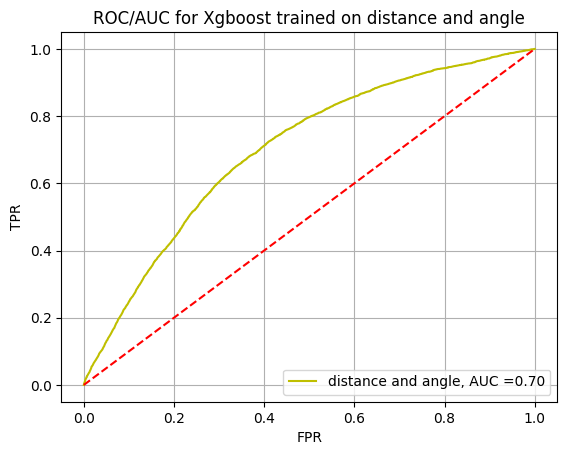

In [160]:
xgboost1=load(xgboost1_path)
val_res = xgboost1.predict_proba(val_X_1)
fpr,tpr,threshold,roc_auc_score = roc_auc_plot(val_Y_1,val_res,'Xgboost','distance and angle')

In [196]:
precision_1 = metrics.precision_score(val_Y_1,xgboost1.predict(val_X_1))
recall_1= metrics.recall_score(val_Y_1,xgboost1.predict(val_X_1))

##### Goal rate

In [163]:
probas_and_label = helper_df(val_Y_1,val_res)
probas_and_label

,is_goal,goal_proba,#goal+#shot,#goal,#goal/#goal+#shot,rank,goal_prob_sum,goal_prob_cumulative_sum,cum_percent
112161,1,0.654373,1,0.0,0.000000,99.999221,952631.01082,0.000000,0.000000
198479,0,0.654373,2,1.0,50.000000,99.999221,952631.01082,50.000000,0.005249
187881,0,0.641880,3,1.0,33.333333,99.996107,952631.01082,83.333333,0.008748
1400,0,0.641880,4,1.0,25.000000,99.996107,952631.01082,108.333333,0.011372
86494,1,0.611886,5,1.0,20.000000,99.990657,952631.01082,128.333333,0.013471
...,...,...,...,...,...,...,...,...,...
172428,0,0.000782,64218,5905.0,9.195241,0.005450,952631.01082,952594.231287,99.996139
50639,0,0.000782,64219,5905.0,9.195098,0.005450,952631.01082,952603.426385,99.997104
267596,0,0.000782,64220,5905.0,9.194955,0.005450,952631.01082,952612.621340,99.998070
245298,0,0.000782,64221,5905.0,9.194812,0.005450,952631.01082,952621.816152,99.999035


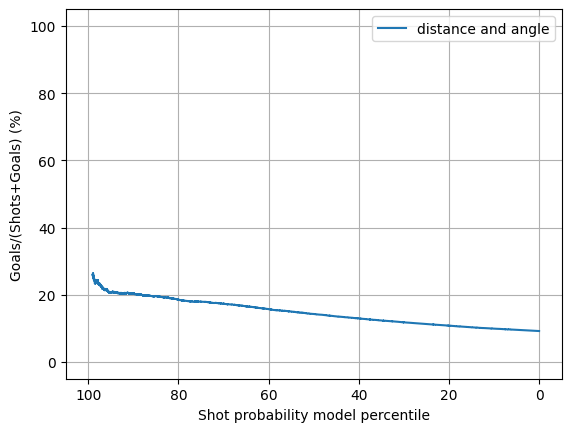

In [164]:
start_length = int(len(probas_and_label)*0.01)
plt.plot(probas_and_label['rank'].iloc[start_length:],probas_and_label['#goal/#goal+#shot'].iloc[start_length:],label="distance and angle")
plt.xlim([105,-5])
plt.ylim([-5,105])
plt.grid(True)
plt.ylabel("Goals/(Shots+Goals) (%)")
plt.xlabel("Shot probability model percentile")
plt.legend()

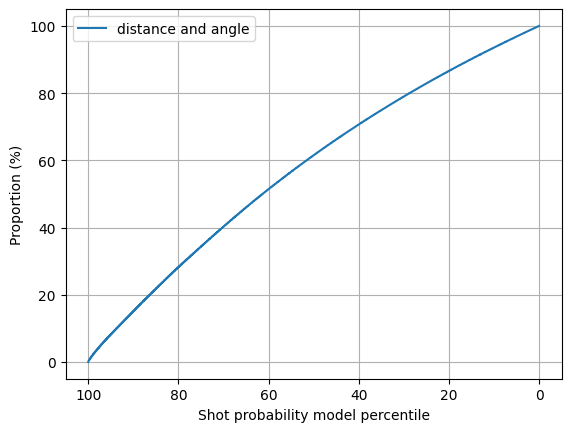

In [12]:
plt.plot(probas_and_label['rank'],probas_and_label['cum_percent'],label="distance and angle")
plt.xlim([105,-5])
plt.ylim([-5,105])
plt.grid(True)
plt.ylabel("Proportion (%)")
plt.xlabel("Shot probability model percentile")
plt.legend()

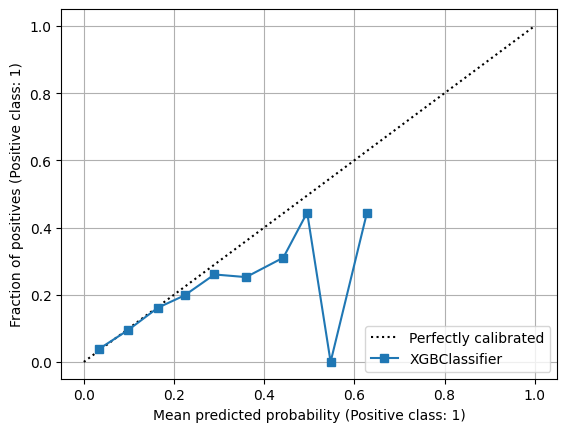

In [165]:
disp = CalibrationDisplay.from_estimator(xgboost1,val_X_1,val_Y,n_bins=15)
plt.grid(True)

### 1. Train with **features in part4**

In [166]:
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from bayes_opt import BayesianOptimization

In [167]:
train_val_df_2=train_val_df[['game_time','period','x','y','shot_type','last_event_type',
       'x_coord_last_event', 'y_coord_last_event', 'Time_from_the_last_event',
       'Distance_from_the_last_event', 'Rebound', 'change_shot_angle', 'Speed',
       'angle_net', 'is_goal']]

##### One hot encoding 

In [168]:
train_val_2_shot_type_oh = onehot_generator(train_val_df_2[['shot_type']])
train_val_2_last_event_type_oh = onehot_generator(train_val_df_2[['last_event_type']])


In [169]:
train_val_df_2= train_val_df_2.drop(columns=['shot_type','last_event_type'])

In [170]:
train_val_df_2 = pd.concat([train_val_df_2,
                       train_val_2_shot_type_oh.set_index(train_val_df_2.index),
                       train_val_2_last_event_type_oh.set_index(train_val_df_2.index)],axis=1)

In [171]:
train_val_df_2

,game_time,period,x,y,x_coord_last_event,y_coord_last_event,Time_from_the_last_event,Distance_from_the_last_event,Rebound,change_shot_angle,...,last_event_type_Missed Shot,last_event_type_Official Challenge,last_event_type_Penalty,last_event_type_Period End,last_event_type_Period Ready,last_event_type_Period Start,last_event_type_Shootout Complete,last_event_type_Shot,last_event_type_Stoppage,last_event_type_Takeaway
0,9,1,-35.0,29.0,0.0,0.0,9,45.453273,False,NaN,...,0,0,0,0,0,0,0,0,0,0
1,10,1,-85.0,8.0,-35.0,29.0,1,54.230987,True,-35.197503,...,0,0,0,0,0,0,0,1,0,0
2,243,1,-53.0,15.0,54.0,35.0,43,108.853112,False,NaN,...,0,0,0,0,0,0,0,0,0,0
3,253,1,55.0,21.0,-53.0,15.0,10,108.166538,True,25.671421,...,0,0,0,0,0,0,0,1,0,0
4,349,1,-79.0,-16.0,-66.0,-32.0,56,20.615528,False,NaN,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267801,1001,3,-59.0,-24.0,64.0,-26.0,3,123.016259,False,NaN,...,0,0,0,0,0,0,0,0,0,0
267802,1080,3,-81.0,3.0,-80.0,6.0,2,3.162278,False,NaN,...,0,0,0,0,0,0,0,0,0,0
267803,1170,3,34.0,-6.0,92.0,-16.0,8,58.855756,False,NaN,...,0,0,0,0,0,0,0,0,0,1
267804,1207,3,31.0,10.0,69.0,-22.0,5,49.678969,False,NaN,...,0,0,0,0,0,0,0,0,0,0


In [172]:
train_val_df_2.columns

Index(['game_time', 'period', 'x', 'y', 'x_coord_last_event',
       'y_coord_last_event', 'Time_from_the_last_event',
       'Distance_from_the_last_event', 'Rebound', 'change_shot_angle', 'Speed',
       'angle_net', 'is_goal', 'shot_type_Backhand', 'shot_type_Deflected',
       'shot_type_Slap Shot', 'shot_type_Snap Shot', 'shot_type_Tip-In',
       'shot_type_Wrap-around', 'shot_type_Wrist Shot', 'shot_type_nan',
       'last_event_type_Blocked Shot', 'last_event_type_Faceoff',
       'last_event_type_Game Official', 'last_event_type_Giveaway',
       'last_event_type_Goal', 'last_event_type_Hit',
       'last_event_type_Missed Shot', 'last_event_type_Official Challenge',
       'last_event_type_Penalty', 'last_event_type_Period End',
       'last_event_type_Period Ready', 'last_event_type_Period Start',
       'last_event_type_Shootout Complete', 'last_event_type_Shot',
       'last_event_type_Stoppage', 'last_event_type_Takeaway'],
      dtype='object')

In [174]:
train_X_2,train_Y_2,val_X_2,val_Y_2 = split_data(train_val_df_2,['game_time', 'period', 'x', 'y', 'x_coord_last_event',
       'y_coord_last_event', 'Time_from_the_last_event',
       'Distance_from_the_last_event', 'Rebound', 'change_shot_angle', 'Speed',
       'angle_net', 'shot_type_Backhand', 'shot_type_Deflected',
       'shot_type_Slap Shot', 'shot_type_Snap Shot', 'shot_type_Tip-In',
       'shot_type_Wrap-around', 'shot_type_Wrist Shot', 'shot_type_nan',
       'last_event_type_Blocked Shot', 'last_event_type_Faceoff',
       'last_event_type_Game Official', 'last_event_type_Giveaway',
       'last_event_type_Goal', 'last_event_type_Hit',
       'last_event_type_Missed Shot', 'last_event_type_Official Challenge',
       'last_event_type_Penalty', 'last_event_type_Period End',
       'last_event_type_Period Ready', 'last_event_type_Period Start',
       'last_event_type_Shootout Complete', 'last_event_type_Shot',
       'last_event_type_Stoppage', 'last_event_type_Takeaway'],0.25,False)

#### Hyperparameter tuning: Bayesian Optimization

###### ref:
######  https://aiinpractice.com/xgboost-hyperparameter-tuning-with-bayesian-optimization/
###### https://zhuanlan.zhihu.com/p/131216861

In [183]:
params = {
    'learning_rate':(0,1),
    'max_depth':(0,100),
    'min_child_weight':(0,10),
    'subsample':(0,1),
    'colsample_bytree': (0,1),
    'gamma':(0,10),
    'eta':(0,1),
    'n_estimators':(50,100)
}

In [186]:
def xgboost_opti(learning_rate,max_depth,min_child_weight,subsample,colsample_bytree,gamma,eta,n_estimators):

    xgb = XGBClassifier(learning_rate=learning_rate,
        max_depth=int(max_depth),
        min_child_weight=min_child_weight,
        subsample=subsample,
        colsample_bytree= colsample_bytree,
        gamma=gamma,
        eta=eta,
        n_estimators=int(n_estimators))

    cv_score = cross_val_score(xgb,train_X_2,train_Y_2,cv=3,scoring='roc_auc')
    
    return cv_score.mean()

xgb_bo = BayesianOptimization(f=xgboost_opti,pbounds=params,random_state=1)

In [187]:
xgb_bo.maximize()

|   iter    |  target   | colsam... |    eta    |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------------------
| 1         | 0.6814    | 0.417     | 0.7203    | 0.001144  | 0.3023    | 14.68     | 0.9234    | 59.31     | 0.3456    |
| 2         | 0.7224    | 0.3968    | 0.5388    | 4.192     | 0.6852    | 20.45     | 8.781     | 51.37     | 0.6705    |
| 3         | 0.7267    | 0.4173    | 0.5587    | 1.404     | 0.1981    | 80.07     | 9.683     | 65.67     | 0.6923    |
| 4         | 0.75      | 0.8764    | 0.8946    | 0.8504    | 0.03905   | 16.98     | 8.781     | 54.92     | 0.4211    |
| 5         | 0.7505    | 0.9579    | 0.5332    | 6.919     | 0.3155    | 68.65     | 8.346     | 50.91     | 0.7501    |
| 6         | 0.7294    | 0.8268    | 0.7575    | 7.182     | 0.5956    | 67.88     | 8.318     | 51.26     | 0.3354    |
| 7         | 0.7428    

In [188]:
best_param = xgb_bo.max['params']
best_param

{'colsample_bytree': 0.5647838996766793,
 'eta': 0.8086508162843394,
 'gamma': 9.73763558347701,
 'learning_rate': 0.0899607131650827,
 'max_depth': 47.16191209632081,
 'min_child_weight': 3.0710104703310384,
 'n_estimators': 55.5582866122662,
 'subsample': 0.7479929230375024}

In [189]:

best_param['n_estimators'] = int(best_param['n_estimators'])
best_param['max_depth'] = int(best_param['max_depth'])

In [193]:
xgboost2 = XGBClassifier(**best_param)

In [194]:
xgboost2.fit(train_X_2,train_Y_2)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5647838996766793, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eta=0.8086508162843394, eval_metric=None, feature_types=None,
              gamma=9.73763558347701, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.0899607131650827,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=47, max_leaves=None,
              min_child_weight=3.0710104703310384, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=55,
              n_jobs=None, num_parallel_tree=None, ...)

In [195]:
dump(xgboost2,'./models/xgboost2.joblib')

['./models/xgboost2.joblib']

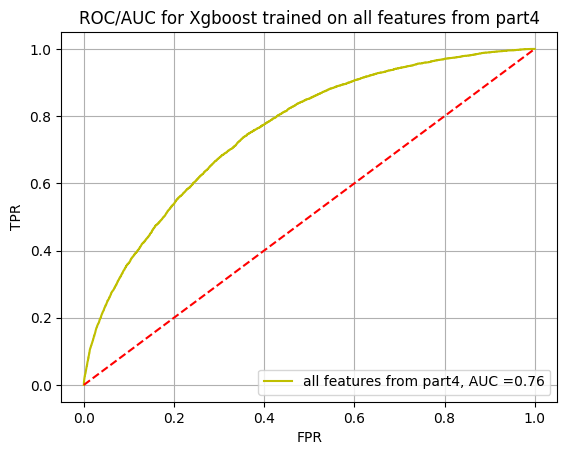

In [202]:

val_res_2 = xgboost2.predict_proba(val_X_2)
fpr,tpr,threshold,roc_auc_score = roc_auc_plot(val_Y_2,val_res_2,'Xgboost','all features from part4')

In [201]:
probas_and_label_2 = helper_df(val_Y_2,val_res_2)
probas_and_label_2

,is_goal,goal_proba,#goal+#shot,#goal,#goal/#goal+#shot,rank,goal_prob_sum,goal_prob_cumulative_sum,cum_percent
147259,1,0.655021,1,0.0,0.000000,100.000000,1.228980e+06,0.000000e+00,0.000000
242868,1,0.621333,2,1.0,50.000000,99.998506,1.228980e+06,5.000000e+01,0.004068
112234,1,0.585436,3,2.0,66.666667,99.997013,1.228980e+06,1.166667e+02,0.009493
243372,1,0.585131,4,3.0,75.000000,99.995519,1.228980e+06,1.916667e+02,0.015596
254726,1,0.581571,5,4.0,80.000000,99.994026,1.228980e+06,2.716667e+02,0.022105
...,...,...,...,...,...,...,...,...,...
54702,0,0.010970,66948,6374.0,9.520822,0.007468,1.228980e+06,1.228942e+06,99.996901
121461,0,0.010906,66949,6374.0,9.520680,0.005974,1.228980e+06,1.228951e+06,99.997676
169832,0,0.010795,66950,6374.0,9.520538,0.004481,1.228980e+06,1.228961e+06,99.998451
202756,0,0.010605,66951,6374.0,9.520396,0.002240,1.228980e+06,1.228970e+06,99.999225


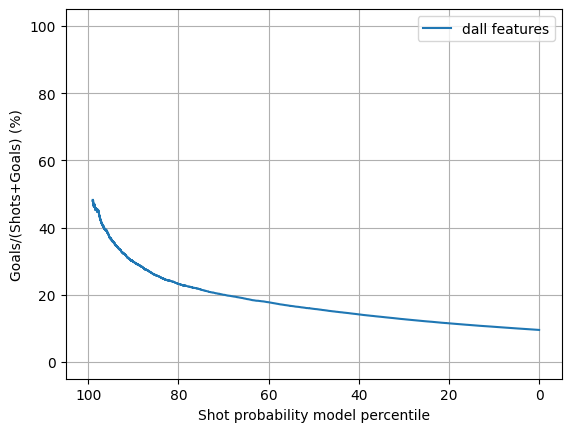

In [203]:
start_length = int(len(probas_and_label_2)*0.01)
plt.plot(probas_and_label_2['rank'].iloc[start_length:],probas_and_label_2['#goal/#goal+#shot'].iloc[start_length:],label="dall features")
plt.xlim([105,-5])
plt.ylim([-5,105])
plt.grid(True)
plt.ylabel("Goals/(Shots+Goals) (%)")
plt.xlabel("Shot probability model percentile")
plt.legend()

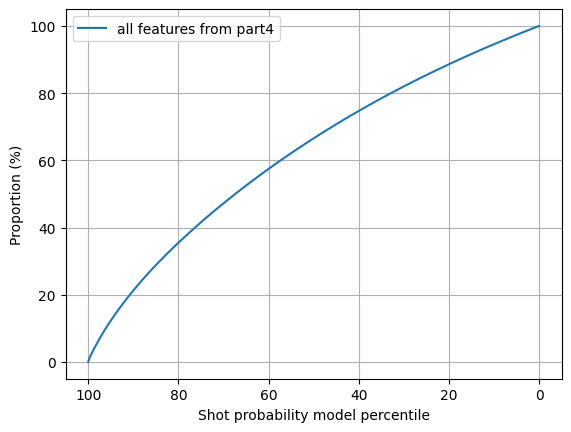

In [205]:
plt.plot(probas_and_label_2['rank'],probas_and_label_2['cum_percent'],label="all features from part4")
plt.xlim([105,-5])
plt.ylim([-5,105])
plt.grid(True)
plt.ylabel("Proportion (%)")
plt.xlabel("Shot probability model percentile")
plt.legend()

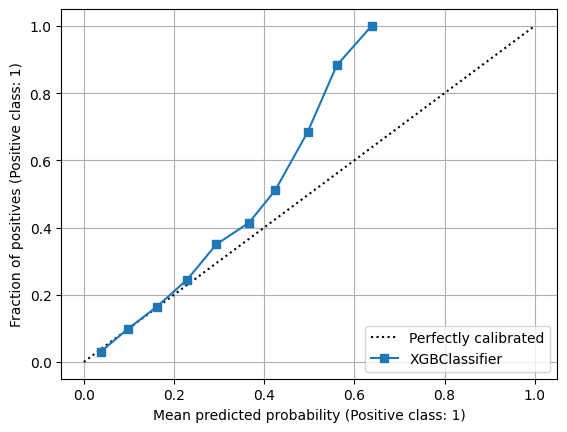

In [206]:
disp = CalibrationDisplay.from_estimator(xgboost2,val_X_2,val_Y_2,n_bins=15)
plt.grid(True)